<a href="https://colab.research.google.com/github/ch-hee/Enefit-ML-project/blob/main/Enefit_BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install polars==0.19.19

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.17.3
    Uninstalling polars-0.17.3:
      Successfully uninstalled polars-0.17.3


In [21]:
import os

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

evaluation_metric = mean_absolute_error

In [2]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target):
    df_data = (
        df_data
        .with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )
    )

    df_client = (
        df_client
        .with_columns(
            (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
        )
    )

    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns(
            (pl.col("date") + pl.duration(days=1)).cast(pl.Date),
            ((pl.col("lowest_price_per_mwh") + pl.col("highest_price_per_mwh")) / 2).alias("mean_price_per_mwh"),
        )
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(
            pl.col("datetime") + pl.duration(days=1)
        )
    )

    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )

    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col("datetime").dt.convert_time_zone("Europe/Bucharest").dt.replace_time_zone(None).cast(pl.Datetime("us")),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )

    df_historical = (
        df_historical
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col("datetime") + pl.duration(hours=37)
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )

    df_forecast_date = (
        df_forecast
        .group_by("datetime").mean()
        .drop("county")
    )

    df_forecast_local = (
        df_forecast
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )

    df_historical_date = (
        df_historical
        .group_by("datetime").mean()
        .drop("county")
    )

    df_historical_local = (
        df_historical
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )

    df_data = (
        df_data
        .join(df_gas, on="date", how="left")

        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")

        .join(df_electricity.with_columns(pl.col("datetime") + pl.duration(days=7)).rename({"euros_per_mwh": "euros_per_mwh_7_days_ago"}), on=["datetime"], how="left")

        .join(df_forecast_date, on="datetime", how="left", suffix="_fd")
        .join(df_forecast_local, on=["county", "datetime"], how="left", suffix="_fl")
        .join(df_historical_date, on="datetime", how="left", suffix="_hd")
        .join(df_historical_local, on=["county", "datetime"], how="left", suffix="_hl")


        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=2)).rename({"target": "target_2_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=3)).rename({"target": "target_3_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=4)).rename({"target": "target_4_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=5)).rename({"target": "target_5_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=6)).rename({"target": "target_6_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=7)).rename({"target": "target_7_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=14)).rename({"target": "target_14_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")

        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
        )

        .with_columns(
            (np.pi * pl.col("dayofyear") / 182.5).sin().alias("sin(dayofyear)"),
            (np.pi * pl.col("dayofyear") / 182.5).cos().alias("cos(dayofyear)"),
            (np.pi * pl.col("weekday") / 3.5).sin().alias("sin(weekday)"),
            (np.pi * pl.col("weekday") / 3.5).cos().alias("cos(weekday)"),
            (np.pi * pl.col("month") / 6).sin().alias("sin(month)"),
            (np.pi * pl.col("month") / 6).cos().alias("cos(month)"),
            (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
            (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
        )

        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )

        .drop("date", "datetime", "hour", "dayofyear")
    )

    return df_data

In [3]:
def to_pandas(X, y=None):
    cat_cols = ["county", "is_business", "product_type", "is_consumption"]

    if y is not None:
        df = pd.concat([X.to_pandas(), y.to_pandas()], axis=1)
    else:
        df = X.to_pandas()

    df = df.set_index("row_id")
    df[cat_cols] = df[cat_cols].astype("category")

    df["target_mean"] = df[[f"target_{i}_days_ago" for i in [2, 3, 4, 5, 6, 7, 14]]].mean(1)
    df["target_std"] = df[[f"target_{i}_days_ago" for i in [2, 3, 4, 5, 6, 7, 14]]].std(1)
    df["target_ratio"] = df["target_7_days_ago"] / (df["target_14_days_ago"] + 1e-3)

    return df

In [4]:
data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols  = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

In [8]:
root = '/content/drive/MyDrive/Data/enefit'

df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_historical  = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "county_location.csv"), columns=location_cols, try_parse_dates=True)
df_target      = df_data.select(target_cols)

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_historical  = df_historical.schema
schema_target      = df_target.schema

In [10]:
X, y = df_data.drop("target"), df_data.select("target")

X = feature_eng(X, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)

df_train = to_pandas(X, y)

In [11]:
df_train = df_train[df_train["target"].notnull() & df_train["year"].gt(2021)]

In [12]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1651902 entries, 366048 to 2018351
Data columns (total 88 columns):
 #   Column                                Non-Null Count    Dtype   
---  ------                                --------------    -----   
 0   county                                1651902 non-null  category
 1   is_business                           1651902 non-null  category
 2   product_type                          1651902 non-null  category
 3   is_consumption                        1651902 non-null  category
 4   lowest_price_per_mwh                  1651902 non-null  float32 
 5   highest_price_per_mwh                 1651902 non-null  float32 
 6   mean_price_per_mwh                    1651902 non-null  float32 
 7   eic_count                             1649502 non-null  float64 
 8   installed_capacity                    1649502 non-null  float32 
 9   euros_per_mwh                         1651634 non-null  float32 
 10  euros_per_mwh_7_days_ago             

In [13]:
six_month = 3000 * 180
train = df_train.iloc[:-six_month]
val = df_train.iloc[-six_month:]
print(len(train), len(val))

1111902 540000


In [14]:
model = LGBMRegressor()
model.fit(train.drop(columns=['target']), train['target'])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.765276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18104
[LightGBM] [Info] Number of data points in the train set: 1111902, number of used features: 86
[LightGBM] [Info] Start training from score 261.757452


LGBMRegressor()

In [19]:
train_mae = evaluation_metric(train['target'], model.predict(train.drop(columns=['target'])))
val_mae = evaluation_metric(val['target'], model.predict(val.drop(columns=['target'])))

print(f'Train mae : {train_mae}')
print(f'Validation mae : {val_mae}')

Train mae : 38.39012691807091
Validation mae : 57.622014433472295


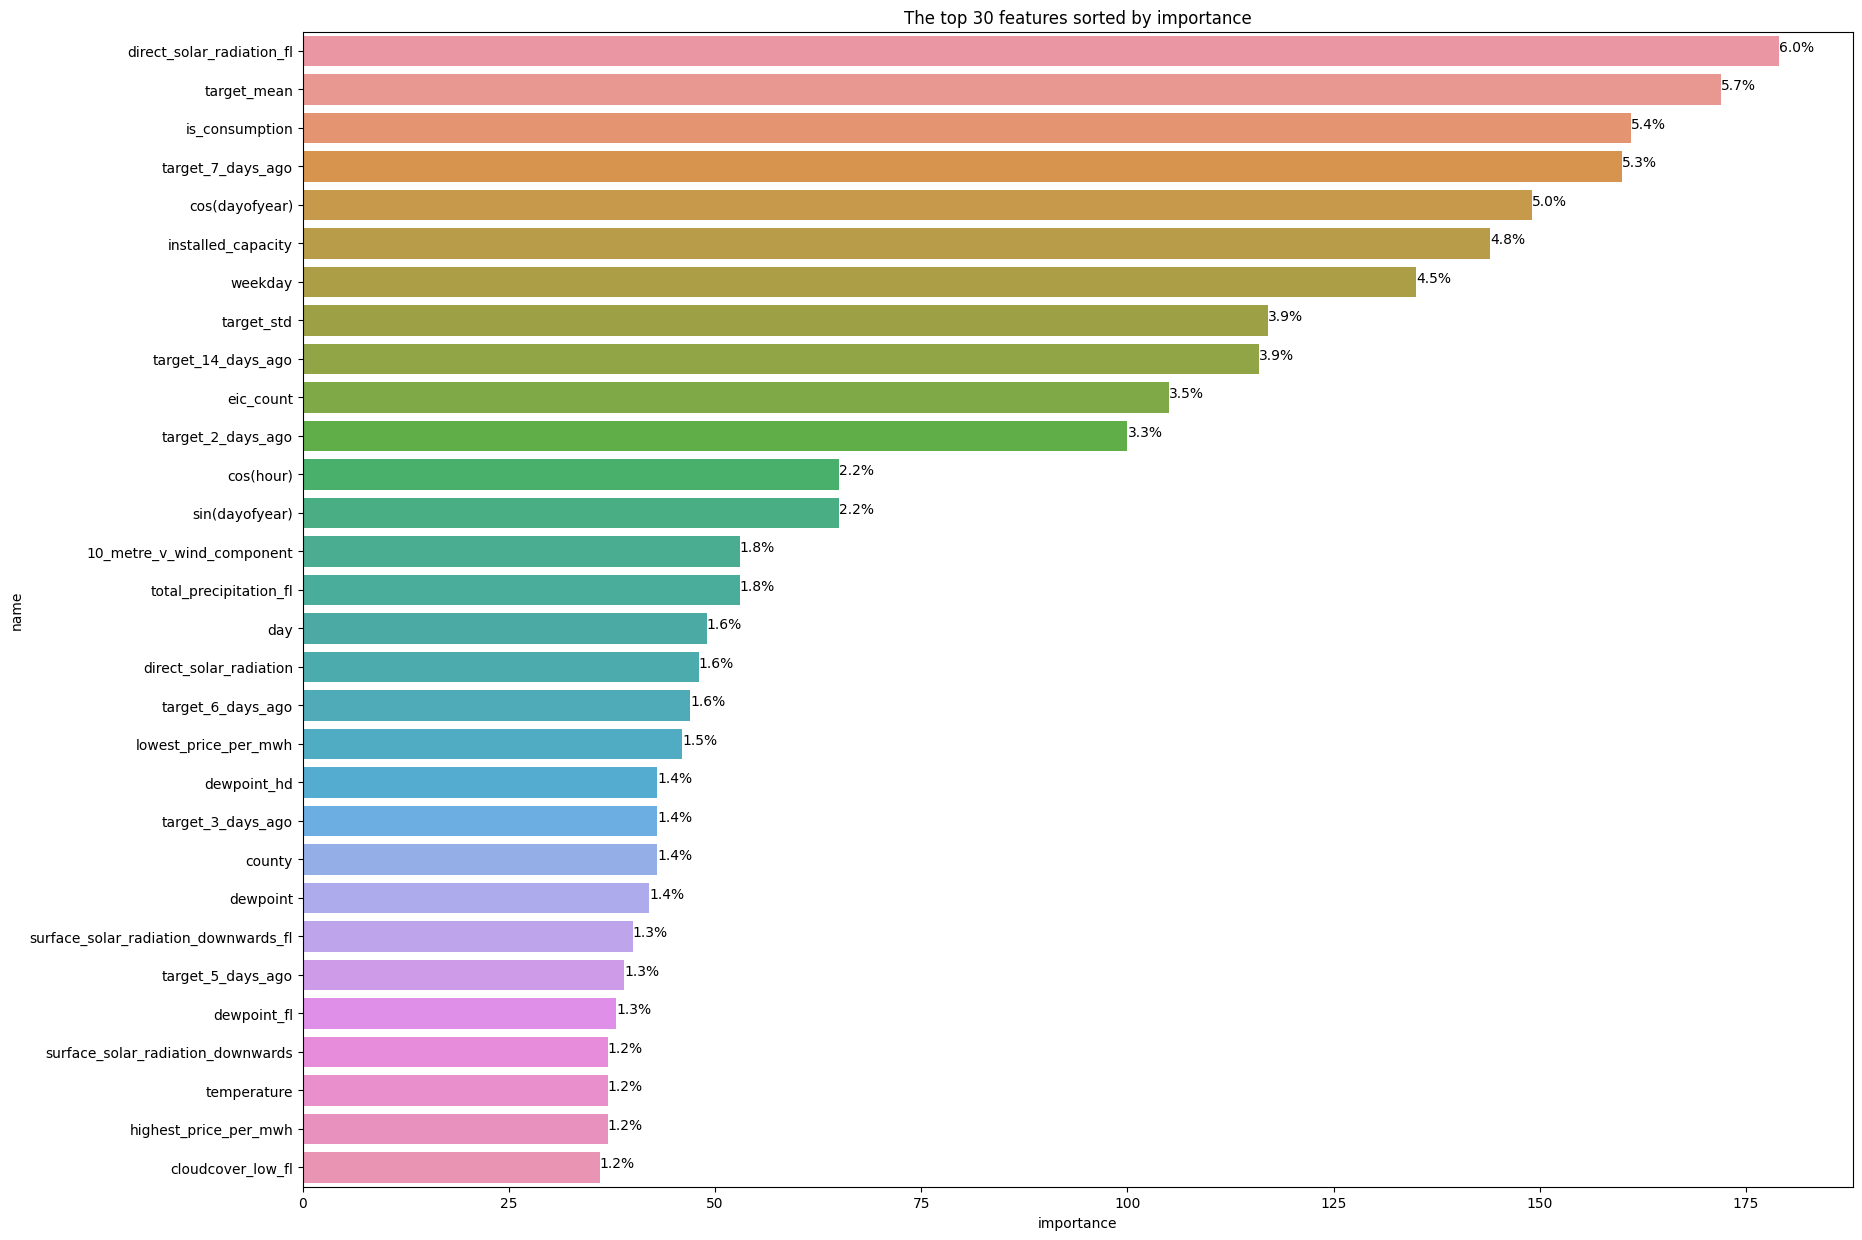

In [22]:
TOP = 30
importance_data = pd.DataFrame({'name': model.feature_name_, 'importance': model.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(data=importance_data[:TOP],
            x='importance',
            y='name'
            )
patches = ax.patches
count = 0
total_importance = importance_data['importance'].sum()  # 전체 중요도의 합을 계산
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    perc = 100 * importance_data['importance'].iloc[count] / total_importance  # 비율 계산
    ax.text(width, patch.get_y() + height / 2, f'{perc:.1f}%')  # 비율 출력
    count += 1

plt.title(f'The top {TOP} features sorted by importance')
plt.show()